In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
import warnings
import logging

logging.getLogger("fbprophet").setLevel(logging.WARNING)
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [3]:
dep = "13"  # Bouches-du-Rhône
nb_days = 9  # forecast horizon (days)
figsize = (12, 7)

In [4]:
covid_url = (
    "https://www.data.gouv.fr/fr/datasets/r/b94ba7af-c0d6-4055-a883-61160e412115"
)

In [5]:
df = pd.read_csv(covid_url, sep=";", parse_dates=True, index_col=2)
df = df.query("sexe == 0")  # sum male/female
df.drop(columns=["sexe"], inplace=True)
df.sort_index(inplace=True)
df.head(2)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,dep,hosp,rea,rad,dc
jour,,,,,
2020-03-18,01,2,0,1,0
2020-03-18,02,41,10,18,11


In [6]:
sdf = df[df["dep"] == dep]

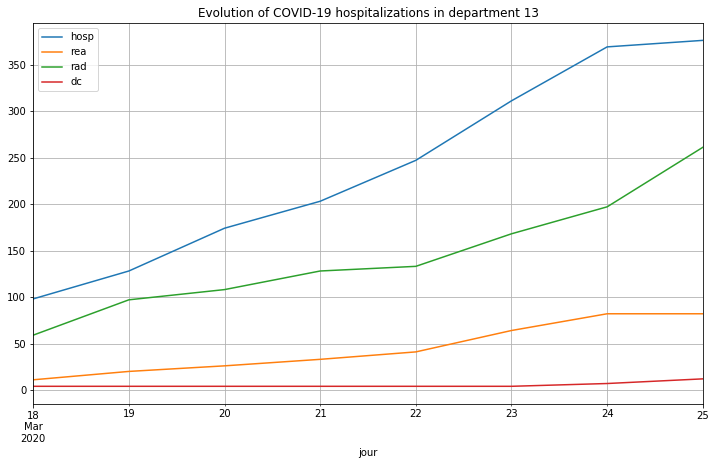

In [7]:
f, ax = plt.subplots(figsize=figsize)
sdf.plot(ax=ax, subplots=False, sharex=True, grid=True)
ax.grid(True, which="both")
ax.set_title("Evolution of COVID-19 hospitalizations in department " + dep)
img_name = dep + "_historical.png"
f.savefig(img_name)
plt.show()

In [8]:
before = sdf.copy()
before = before[["hosp"]]
before.head()

,hosp
jour,
2020-03-18,98
2020-03-19,128
2020-03-20,174
2020-03-21,203
2020-03-22,247


In [9]:
vec = before.copy()
vec = vec.reset_index()
vec = vec[["jour", "hosp"]]
vec.rename(columns={"jour": "ds", "hosp": "y"}, inplace=True)
vec.head(2)

,ds,y
0,2020-03-18,98
1,2020-03-19,128


In [10]:
m = Prophet(changepoint_prior_scale=0.05)
m.fit(vec)

In [11]:
future = m.make_future_dataframe(periods=nb_days)
forecast = m.predict(future)

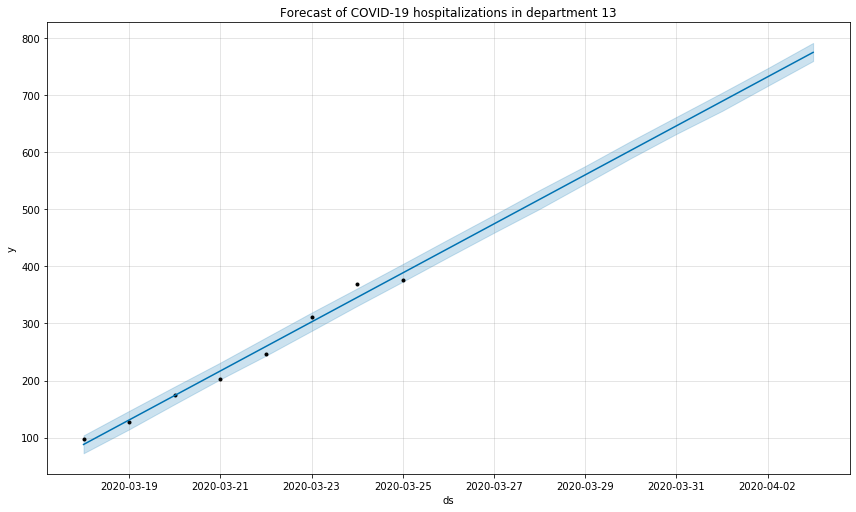

In [12]:
f, ax = plt.subplots(figsize=figsize)
fig = m.plot(forecast, ax=ax)
ax.set_title("Forecast of COVID-19 hospitalizations in department " + dep)
img_name = dep + "_forecast.png"
f.savefig(img_name)

In [13]:
after = forecast.copy()
after = after[["ds", "trend"]]
after.rename(columns={"ds": "jour", "trend": "hosp"}, inplace=True)
last_date = before.index.max()
after = after[after["jour"] > last_date]
after.set_index("jour", inplace=True)
after["hosp"] = after["hosp"].apply(np.int64)
after.head(2)

,hosp
jour,
2020-03-26,431
2020-03-27,474


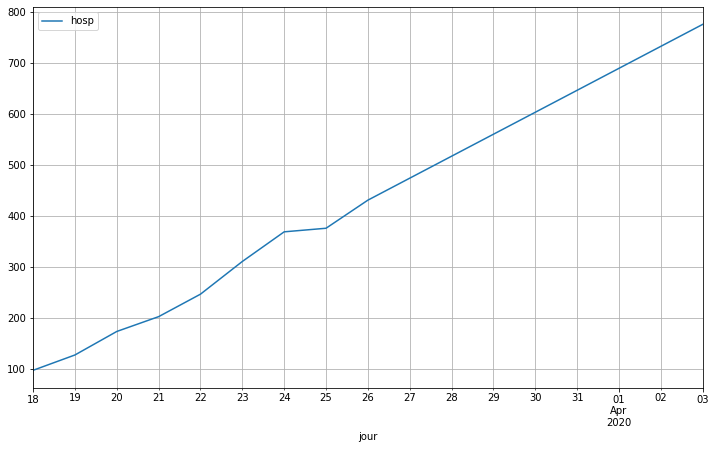

In [14]:
tot = pd.concat([before, after])
f, ax = plt.subplots(figsize=figsize)
tot.plot(ax=ax)
ax.grid(True, which="both")
plt.show()